In [375]:
# Chapter 9, Exercise 6
# Packages/options:
rm(list=ls())
# For svm() function
library(e1071)
# Number of observations:
num_obs      <- 10
num_obs_test <- 1000
# Bandwidth of 1st feature:
abs_uni <- 10
# Systemic separation to generate x2
sys_sep <- 7
# Noise standard deviation:
nse_sd  <- 6

In [376]:
# Part a:
# Generate a two-class data set with p=2 in a way that the two classes
# are just linearly separable:
set.seed(1)
x1 <- runif(num_obs, min=-abs_uni, max=abs_uni)
head(x1, 5)

[1] -4.689827 -2.557522  1.457067  8.164156 -5.966361

In [377]:
# Arbitrarily set the first num_obs/2 values of the response variable
# equal to red, the rest to blue:
cols <- c(rep('red',num_obs/2), rep('blue',num_obs/2))
# Inspect to see the switch:
begin_view <- num_obs/2-2
end_view   <- num_obs/2+2
print(cols[begin_view:end_view])

[1] "red"  "red"  "red"  "blue" "blue"


In [378]:
# I'd like the linear separation to be of the form x2=2,
# plus or minus some noise.
# Raise up red entries above the divider, allow blue to
# sink down below:
col_ind <- ifelse(cols=='red', 1, -1)
print(col_ind[begin_view:end_view])
noise     <- rnorm(num_obs, mean=0, sd=nse_sd)
print(head(noise))
x2        <- (2+col_ind*sys_sep+noise)
print(head(x2))

[1]  1  1  1 -1 -1
[1] -4.922810  2.924574  4.429948  3.454688 -1.832330  9.070687
[1]  4.077190 11.924574 13.429948 12.454688  7.167670  4.070687


In [379]:
twoclass_df <- data.frame(cols, x1, x2)
head(twoclass_df)

,cols,x1,x2
,<fct>,<dbl>,<dbl>
1,red,-4.689827,4.077190
2,red,-2.557522,11.924574
3,red,1.457067,13.429948
4,red,8.164156,12.454688
5,red,-5.966361,7.167670
6,blue,7.967794,4.070687


The following objects are masked _by_ .GlobalEnv:

    cols, x1, x2




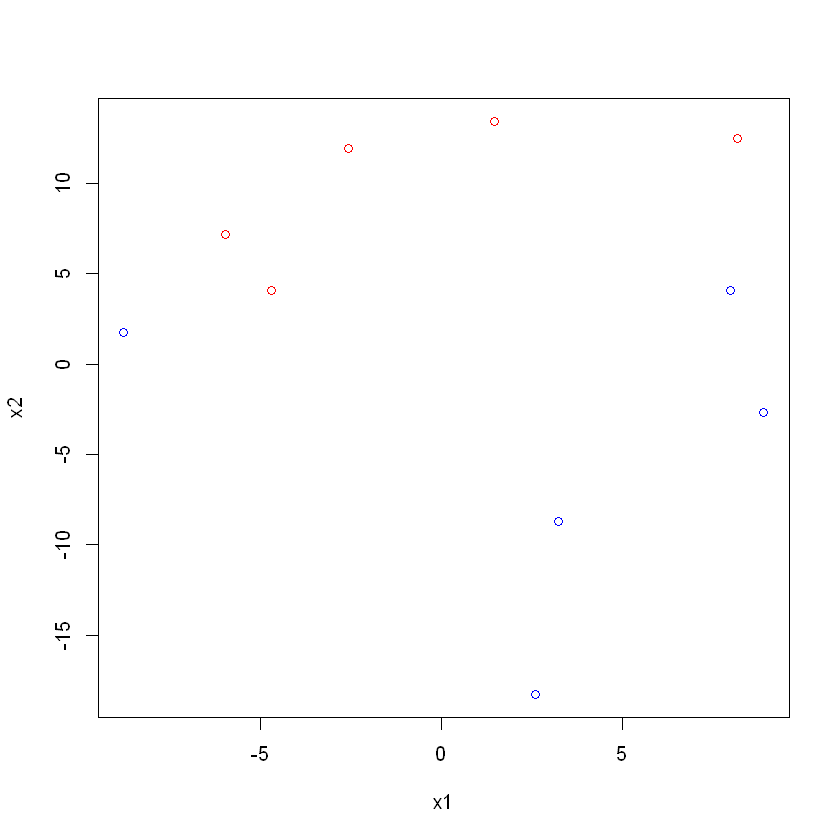

In [380]:
# Plot:
attach(twoclass_df); 
plot(twoclass_df$x1, twoclass_df$x2, col=c("blue","red")[twoclass_df$cols],
    xlab="x1", ylab="x2") 
detach(twoclass_df)
# There is clearly a visible separation between the two classes.

In [381]:
# Code Red==1, Blue==-1
twoclass_df$y  <- as.factor(ifelse(twoclass_df$cols=="red", 1, -1))
print(head(twoclass_df))
twoclass_clean <- twoclass_df[,-c(1)]
print(head(twoclass_clean))

  cols        x1        x2  y
1  red -4.689827  4.077190  1
2  red -2.557522 11.924574  1
3  red  1.457067 13.429948  1
4  red  8.164156 12.454688  1
5  red -5.966361  7.167670  1
6 blue  7.967794  4.070687 -1
         x1        x2  y
1 -4.689827  4.077190  1
2 -2.557522 11.924574  1
3  1.457067 13.429948  1
4  8.164156 12.454688  1
5 -5.966361  7.167670  1
6  7.967794  4.070687 -1


In [382]:
# Verify that these two classes are indeed linearly separable
# by training a SVC with a very high value of cost.
svmfit   <- svm(y~., data=twoclass_clean, kernel="linear", cost=10000)
# ls(svmfit)
table(svmfit$fitted, twoclass_clean$y)
# Clearly, the above SVC predicts all obs correctly on the train data, and thus
# this two feature, two class data is linearly separable.

    
     -1 1
  -1  5 0
  1   0 5

In [383]:
# Part b:
# Compute CV error rates for SVCs with different values of the cost parm:
set.seed(1)
tune.out <- tune(svm, y~., data=twoclass_clean, kernel="linear", 
                 ranges=list(cost=c(0.001, 0.01, 0.1, 10, 100)))
summary(tune.out)
# ls(tune.out)


Parameter tuning of 'svm':

- sampling method: leave-one-out 

- best parameters:
 cost
   10

- best performance: 0.3 

- Detailed performance results:
   cost error dispersion
1 1e-03   1.0  0.0000000
2 1e-02   1.0  0.0000000
3 1e-01   0.5  0.5270463
4 1e+01   0.3  0.4830459
5 1e+02   0.3  0.4830459


In [384]:
# Compute train errors for each value of cost:
cost_vec <- c(0.001, 0.01, 0.1, 10, 100)
misclass <- rep(0, length(cost_vec))
set.seed(1)
for (i in 1:length(cost_vec))
{
    svmfit_temp <- svm(y~., data=twoclass_clean, kernel="linear", cost=cost_vec[i])
    conf_matrix <- table(svmfit_temp$fitted, twoclass_clean$y)
    misclass[i] <- (conf_matrix[2,1]+conf_matrix[1,2])
    
}
misclass_rt <- misclass/nrow(twoclass_clean)
print(misclass)
print(misclass_rt)

[1] 2 2 2 1 0
[1] 0.2 0.2 0.2 0.1 0.0


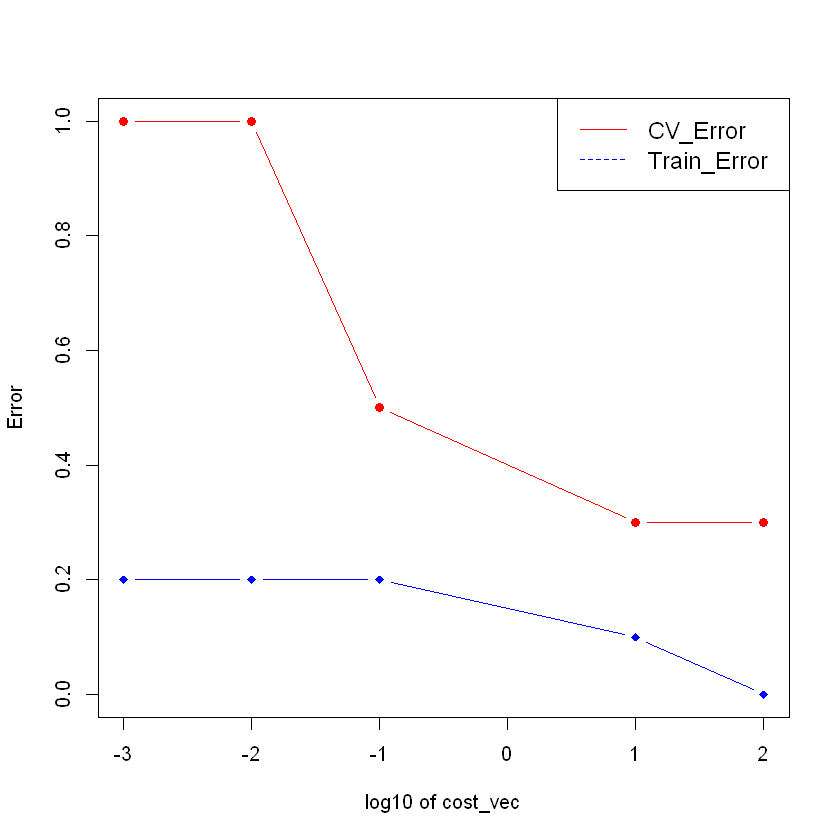

In [385]:
# The number of train errors obtained for each value of cost is above.
# This roughly aligns with the CV indications: namely both train error and CV indicate
# that a higher value of the cost parm is better.
cost_vec_log10 <- log10(cost_vec)
plot(cost_vec_log10, tune.out$performances[,2], xlab="log10 of cost_vec",
    ylab="Error", pch=19, type="b", ylim=c(0,1), col="red")
lines(cost_vec_log10, misclass_rt, pch=18, type="b", col="blue")
legend("topright", legend=c("CV_Error", "Train_Error"), col=c("red", "blue"), lty=1:2, cex=1.2)

In [386]:
# Part c:
# Generate an appropriate test data set:
set.seed(2)
# Define x1:
x1 <- runif(num_obs_test, min=-abs_uni, max=abs_uni)
# Define y:
test_cols <- c(rep('red',num_obs_test/2), rep('blue',num_obs_test/2))
# Define x2:
test_col_ind <- ifelse(test_cols=='red', 1, -1)
test_noise   <- rnorm(num_obs_test, mean=0, sd=nse_sd)
x2        <- (2+col_ind*sys_sep+noise)
print(head(x2))

[1]  4.077190 11.924574 13.429948 12.454688  7.167670  4.070687


In [387]:
twoclass_df_test <- data.frame(test_cols, x1, x2)
head(twoclass_df_test)
twoclass_df_test$y  <- as.factor(ifelse(twoclass_df_test$test_cols=="red", 1, -1))
print(head(twoclass_df_test))
twoclass_clean_test <- twoclass_df_test[,-c(1)]
print(head(twoclass_clean_test))
nrow(twoclass_clean_test)

,test_cols,x1,x2
,<fct>,<dbl>,<dbl>
1,red,-6.302355,4.077190
2,red,4.047481,11.924574
3,red,1.466527,13.429948
4,red,-6.638962,12.454688
5,red,8.876787,7.167670
6,red,8.869499,4.070687


  test_cols        x1        x2 y
1       red -6.302355  4.077190 1
2       red  4.047481 11.924574 1
3       red  1.466527 13.429948 1
4       red -6.638962 12.454688 1
5       red  8.876787  7.167670 1
6       red  8.869499  4.070687 1
         x1        x2 y
1 -6.302355  4.077190 1
2  4.047481 11.924574 1
3  1.466527 13.429948 1
4 -6.638962 12.454688 1
5  8.876787  7.167670 1
6  8.869499  4.070687 1


[1] 1000

In [388]:
# Compute test errors for each value of cost:
misclass_test <- rep(0, length(cost_vec))
set.seed(1)
for (i in 1:length(cost_vec))
{
    svmfit_temp <- svm(y~., data=twoclass_clean, kernel="linear", cost=cost_vec[i])
    preds_temp  <- predict(svmfit_temp, newdata=twoclass_clean_test)
    conf_matrix_test <- table(preds_temp, twoclass_clean_test$y)
    misclass_test[i] <- (conf_matrix_test[2,1]+conf_matrix_test[1,2])
    
}
misclass_test_rt <- misclass_test/nrow(twoclass_clean_test)
print(head(misclass_test_rt))

[1] 0.496 0.496 0.497 0.497 0.515


In [389]:
# Clearly cost values of 10^-3 and 10^-2 yield the lowest error rate on a test set.
# This disagrees with the indication from CV on training set (which indicated 10^1 and 10^2),
# and also disagrees with the indication from the training error set which indicated 10^2.

In [390]:
# Part d:
# Clearly, I have constructed an artificial data set that satisfies the goal of this question.
# I constructed a DGP of the form x2=2, with both a systemic separation of +/- 7 based on 
# the color, and some normally-distributed noise.  The optimal decison boundary should be 
# described by 1 parm: the mean of 2.
# With so few obs, the SVC's estimation will be very imprecise, and thus intuitively we should 
# lean towards simpler models with more bias and less variance, since variance is such a huge 
# concern here. Not surprisingly, since we required that the training data be linearly separable, 
# SVCs with very high values of the cost parameter are able to perfectly separate the two classes 
# (with significant overfitting), and are indicated as optimal by both the train data (which 
# doesn't say much) and CV (which is of limited use in this case, with limited data).
# However, SVCs with low values of the cost parm choose simpler models and tolerate a few 
# misclassified values of the training data, and while performing worse on training error and CV on 
# training data, produce lower test error rates as their parsimony pays off in the long run, 
# which is what the problem seeks to show.